# RoBERTa Classifier with IMSLP LM pretraining & finetuning

In this notebook we will train a RoBERTa classifier for the proxy task using the language model trained on IMSLP and finetuned on target data for initialization.  The language model is trained in 04_roberta_lm.ipynb.

This notebook is adapted from [this](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2) blog post.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from fastai import *
from fastai.text import *
from transformers import RobertaForSequenceClassification, RobertaConfig
import eval_models
from train_utils import *

/home/kdey/ttmp/micromamba/envs/pse/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import fastai
import transformers
import tokenizers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('tokenizers version :', tokenizers.__version__)

fastai version : 1.0.59
transformers version : 3.0.2
tokenizers version : 0.8.1.rc1


In [5]:
torch.cuda.set_device(1)

### Prep databunch

In [6]:
bs = 64
seed = 42
tok_model_dir = Config.data_path()/'bscore_lm/bpe_data/tokenizer_imslp'
max_seq_len = 256

In [7]:
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [8]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')

In [9]:
bpe_path = Config.data_path()/'bscore_lm/bpe_data'
train_df = pd.read_csv(bpe_path/'train64.char.csv')
valid_df = pd.read_csv(bpe_path/'valid64.char.csv')
test_df = pd.read_csv(bpe_path/'test64.char.csv')

In [10]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

/home/kdey/ttmp/micromamba/envs/pse/lib/python3.7/site-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Train Classifier

In [11]:
model_class, config_class = RobertaForSequenceClassification, RobertaConfig
model_path = Config.data_path()/'bscore_lm/bpe_data/models/roberta_train-imslp_finetune-target_lm'

In [12]:
config = config_class.from_pretrained(model_path)
config.num_labels = data_clas.c

In [13]:
transformer_model = model_class.from_pretrained(model_path, config = config)
custom_transformer_model = RobertaModelWrapper(transformer_model, pad_idx)

Some weights of the model checkpoint at /home/kdey/.fastai/data/bscore_lm/bpe_data/models/roberta_train-imslp_finetune-target_lm were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /home/kdey/.fastai/data/bscore_lm/bpe_

In [14]:
# learner.destroy()
# torch.cuda.empty_cache()

In [15]:
learner = Learner(data_clas, custom_transformer_model, metrics=[accuracy, FBeta(average='macro', beta=1)])

In [16]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.pooler]

In [17]:
learner.split(list_layers)
print(learner.layer_groups)

[Sequential(
  (0): Embedding(30000, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, o

In [18]:
seed_all(seed)

In [19]:
learner.freeze_to(-1)

In [20]:
#learner.summary()

In [21]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-04
Min loss divided by 10: 3.63E-04


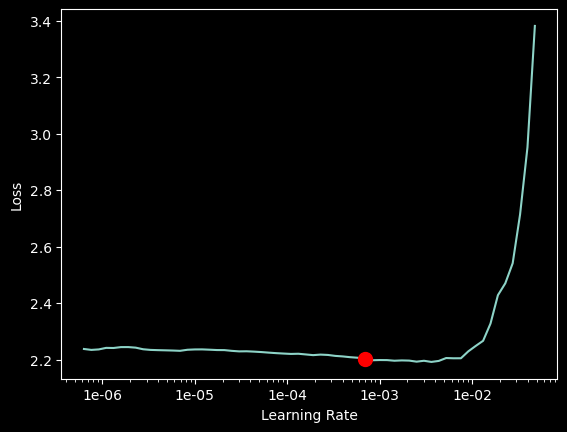

In [22]:
learner.recorder.plot(suggestion=True)

In [23]:
lr = 1e-3

In [24]:
learner.fit_one_cycle(4, lr, moms=(0.8,0.7))

KeyboardInterrupt: 

In [ ]:
learner.fit_one_cycle(3, lr, moms=(0.8,0.7))

In [ ]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8, 0.9))

In [ ]:
learner.freeze_to(-3)
learner.fit_one_cycle(3, slice(lr/2/(2.6**4),lr/2), moms=(0.8, 0.9))

In [ ]:
learner.save('roberta_train-imslp_finetune-target_clas')
#learner.load('roberta_train-imslp_finetune-target_clas')

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [ ]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_df, test_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [ ]:
learner.validate(data_clas_test.valid_dl)

[1.9605404, tensor(0.4652), tensor(0.4646)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [ ]:
train_fullpage_df = pd.read_csv(bpe_path/'train.fullpage.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'valid.fullpage.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'test.fullpage.char.csv')

In [ ]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

/home/kdey/ttmp/micromamba/envs/pse/lib/python3.7/site-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df, databunch=data_clas_test)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.4534115791320801, 0.48789435625076294),
 (0.41085844541161365, 0.4230324117845111))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [ ]:
test_ensemble_df = pd.read_csv(bpe_path/'test.ensemble64.char.csv')

In [ ]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df,
                                       text_cols = 'text', label_cols = 'label', tokenizer=cust_tok, 
                                       vocab=transformer_vocab, include_bos=False, include_eos=False, 
                                       pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [ ]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, databunch=data_clas_test, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.6192222833633423, 0.6192222833633423),
 (0.5893665505950731, 0.5288875944679167))

### Error Analysis

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

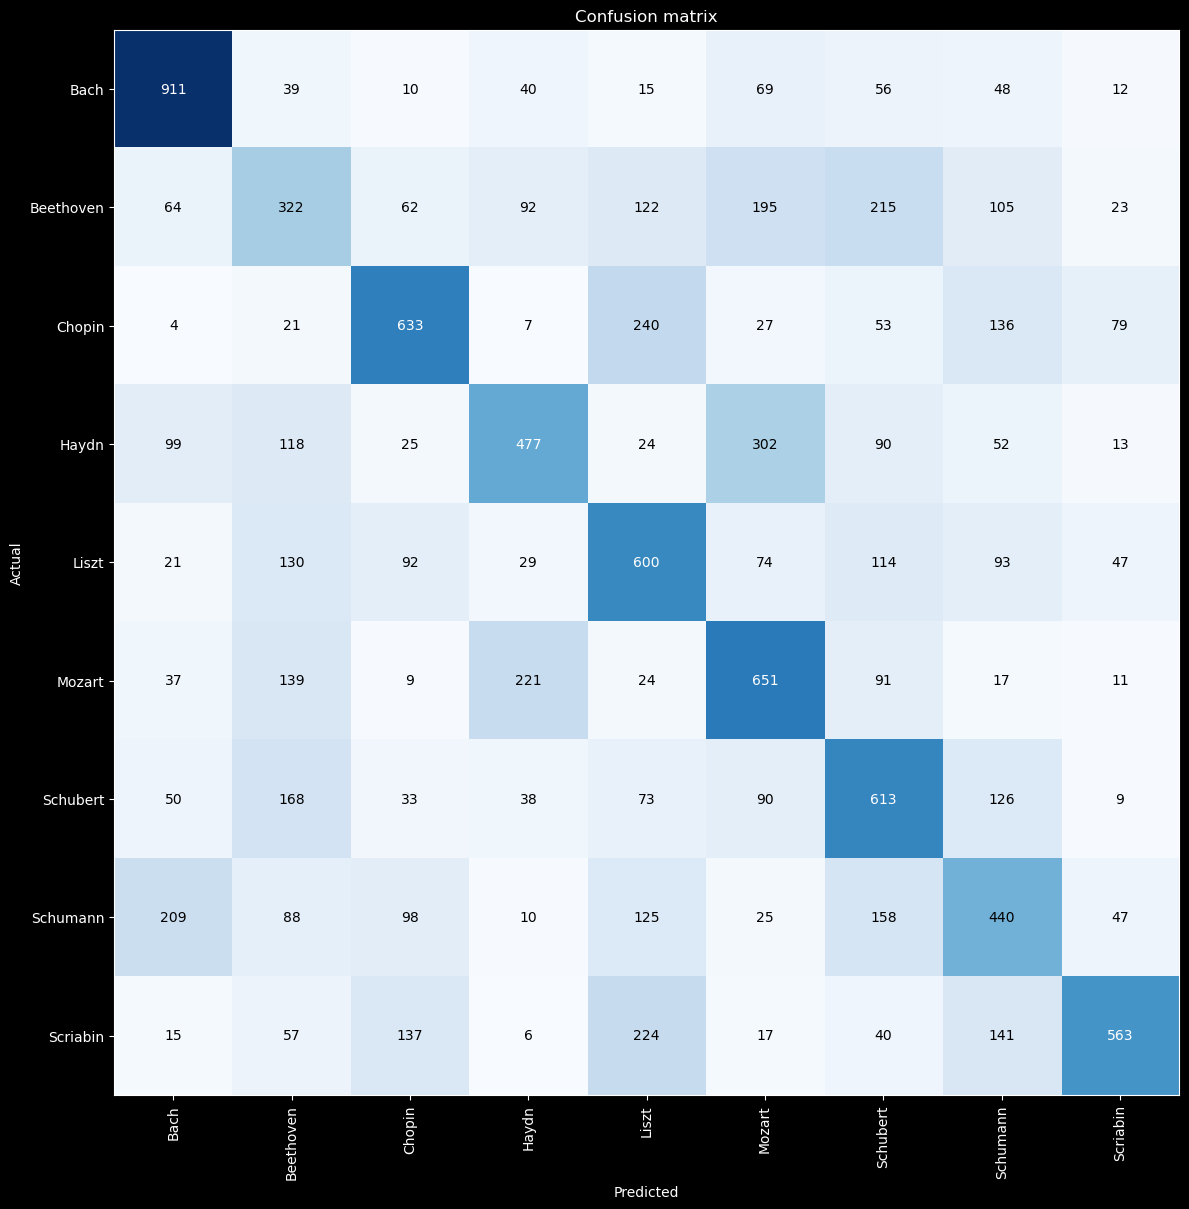

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12))